In [1]:
import numpy as np
import nibabel as nib
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import os
import tarfile
from tqdm import tqdm
import time
import glob


2025-08-24 23:42:19.923845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756078940.092330      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756078940.145333      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class Constants:
#A single class to manage all hyperparameters and settings.
    INPUT_PATH = "/kaggle/input/brats-2021-task1"
    WORKING_PATH = "/kaggle/working/brats2021"
    OUTPUT_PATH = "/kaggle/working"
    TARGET_SIZE = (128, 128)
    RANDOM_STATE = 42 
    NUM_PRETRAIN_CASES = 100
    NUM_BOX_TRAIN_CASES = 100
    NUM_VAL_CASES = 30
    BATCH_SIZE = 16
    LEARNING_RATE_PRETRAIN = 1e-4
    LEARNING_RATE_FINETUNE_FROZEN = 1e-4
    LEARNING_RATE_FINETUNE_UNFROZEN = 1e-5
    EPOCHS_PRETRAIN = 20
    EPOCHS_PHASE_1 = 15
    EPOCHS_PHASE_2 = 15
    BOX_CONSTRAINT_WEIGHT = 0.3
    BOXY_PRIOR_WEIGHT = 0.7

#Random seeds for reproducibility
if Constants.RANDOM_STATE:
    np.random.seed(Constants.RANDOM_STATE)
    tf.random.set_seed(Constants.RANDOM_STATE)

BRATS_PATH = Constants.WORKING_PATH

# Record the time to measure total script runtime.
start_time = time.time()

#Data Extraction and Preparation

if os.path.exists(Constants.INPUT_PATH):
    os.makedirs(Constants.WORKING_PATH, exist_ok=True)
    tar_files = [fname for fname in os.listdir(Constants.INPUT_PATH) if fname.endswith('.tar')]
    print("Starting data extraction...")
    for fname in tqdm(tar_files, desc="Extracting .tar files"):
        tar_path = os.path.join(Constants.INPUT_PATH, fname)
        if fname in ["BraTS2021_00495.tar", "BraTS2021_00621.tar"]:
            case_id = fname.replace('.tar', '')
            case_specific_path = os.path.join(Constants.WORKING_PATH, case_id)
            os.makedirs(case_specific_path, exist_ok=True)
            with tarfile.open(tar_path) as tar:
                tar.extractall(path=case_specific_path)
        else:
            with tarfile.open(tar_path) as tar:
                tar.extractall(path=Constants.WORKING_PATH)
    print("Extraction complete.")
else:
    print(f"Warning: Input path '{Constants.INPUT_PATH}' not found. Skipping extraction.")
    os.makedirs(Constants.WORKING_PATH, exist_ok=True)



Starting data extraction...


Extracting .tar files: 100%|██████████| 3/3 [01:20<00:00, 26.84s/it]

Extraction complete.


In [3]:
#Data Loading and Preprocessing Functions

def load_brats_case(case_id):
    modalities = ['flair', 't1ce', 't2']
    data = {}
    case_path = os.path.join(BRATS_PATH, case_id)
    for mod in modalities:
        img_path = os.path.join(case_path, f"{case_id}_{mod}.nii.gz")
        data[mod] = nib.load(img_path).get_fdata()
    mask_path = os.path.join(case_path, f"{case_id}_seg.nii.gz")
    mask = nib.load(mask_path).get_fdata()
    return data, mask
def extract_slices(volume_dict, mask, slice_idx):
    return {mod: volume[..., slice_idx] for mod, volume in volume_dict.items()}, mask[..., slice_idx]

def preprocess(data_dict, mask, target_size=(128, 128)):
    img = np.stack([data_dict['flair'], data_dict['t1ce'], data_dict['t2']], axis=-1)
    for i in range(img.shape[-1]):
        channel = img[..., i]
        if np.max(channel) > np.min(channel):
            img[..., i] = (channel - np.min(channel)) / (np.max(channel) - np.min(channel))
        else:
            img[..., i] = 0
    img = resize(img, target_size, order=1, preserve_range=True, anti_aliasing=True)
    mask = resize(mask, target_size, order=0, preserve_range=True, anti_aliasing=False) > 0.5
    return img.astype(np.float32), mask.astype(np.float32), mask.shape[:2]

def mask_to_bbox(mask):
    coords = np.where(mask)
    if coords[0].size == 0:
        return np.array([0, 0, 0, 0], dtype=np.int32)
    y_min, y_max = np.min(coords[0]), np.max(coords[0])
    x_min, x_max = np.min(coords[1]), np.max(coords[1])
    return np.array([y_min, y_max+1, x_min, x_max+1], dtype=np.int32)

def create_boxy_prior_maps(mask, bbox):
    height, width = mask.shape
    y_min, y_max, x_min, x_max = bbox
    if y_max <= y_min or x_max <= x_min:
        return np.zeros((height, width, 4), dtype=np.float32)
    y_coords, x_coords = np.mgrid[:height, :width]
    dist_top = np.maximum(0, (y_coords - y_min)).astype(np.float32) / (height-1)
    dist_bottom = np.maximum(0, (y_max - y_coords)).astype(np.float32) / (height-1)
    dist_left = np.maximum(0, (x_coords - x_min)).astype(np.float32) / (width-1)
    dist_right = np.maximum(0, (x_max - x_coords)).astype(np.float32) / (width-1)
    return np.stack([dist_top, dist_bottom, dist_left, dist_right], axis=-1)

def preprocess_and_save_all_cases(case_ids, output_dir, pretrain_mode=False,
                                  include_negatives=True, neg_pos_ratio=0.5,
                                  max_negs_per_case=20):
    os.makedirs(output_dir, exist_ok=True)
    print(f"Preprocessing data and saving to '{output_dir}'...")
    slices_saved_count = 0
    rng = np.random.default_rng(Constants.RANDOM_STATE)

    for case_id in tqdm(case_ids, desc=f"Processing cases for {os.path.basename(output_dir)}"):
        try:
            data, mask_3d = load_brats_case(case_id)
            pos_idxs = [z for z in range(mask_3d.shape[2]) if np.any(mask_3d[..., z])]
            neg_idxs = [z for z in range(mask_3d.shape[2]) if not np.any(mask_3d[..., z])]

            selected_neg_idxs = []
            if include_negatives and len(neg_idxs) > 0 and len(pos_idxs) > 0:
                target_negs = int(np.ceil(len(pos_idxs) * neg_pos_ratio))
                target_negs = min(target_negs, max_negs_per_case, len(neg_idxs))
                selected_neg_idxs = list(rng.choice(neg_idxs, size=target_negs, replace=False))

            all_idxs = pos_idxs + selected_neg_idxs

            for z in all_idxs:
                img_slices, mask_2d = extract_slices(data, mask_3d, slice_idx=z)
                img, mask, _ = preprocess(img_slices, mask_2d, Constants.TARGET_SIZE)
                save_path = os.path.join(output_dir, f"{case_id}_z{z:03d}.npz")

                if pretrain_mode:
                    np.savez_compressed(save_path, image=img, mask=np.expand_dims(mask, -1))
                else:
                    bbox = mask_to_bbox(mask)
                    boxy_maps = create_boxy_prior_maps(mask, bbox)
                    bbox_broadcast = np.zeros_like(boxy_maps)
                    bbox_broadcast[0, 0, :] = bbox
                    y_true_combined = np.concatenate([
                        np.expand_dims(mask, -1),
                        boxy_maps,
                        bbox_broadcast
                    ], axis=-1).astype(np.float32)
                    np.savez_compressed(save_path, image=img, y_true=y_true_combined)
                slices_saved_count += 1
        except Exception as e:
            print(f"Error processing and saving case {case_id}: {e}. Skipping.")
    print(f"Completed. Saved a total of {slices_saved_count} slices.")

In [4]:
#Model Architecture, Loss, and Metrics

def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def precision(y_true, y_pred, smooth=1e-7):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return (true_positives + smooth) / (predicted_positives + smooth)

def recall(y_true, y_pred, smooth=1e-7):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return (true_positives + smooth) / (possible_positives + smooth)

#ImageNet-based Encoder
def build_encoder_imagenet_compat(input_shape=(128, 128, 3), trainable=True):
    inputs = Input(shape=input_shape)
    x_in = Lambda(lambda z: 2.0*z - 1.0, name="imagenet_range")(inputs)

    base = MobileNetV2(input_tensor=x_in, include_top=False, weights="imagenet")
    base.trainable = trainable

    # Feature taps at the right spatial scales for 128x128 input
    s1 = base.get_layer('block_1_expand_relu').output   # 64x64
    s2 = base.get_layer('block_3_expand_relu').output   # 32x32
    bn = base.get_layer('block_6_expand_relu').output   # 16x16 (bottleneck)

    # Projecting to match the original decoder channel dimensions: 32, 64, 128
    s1 = Conv2D(32,  1, padding='same', activation='relu', name='proj_skip1_32')(s1)
    s2 = Conv2D(64,  1, padding='same', activation='relu', name='proj_skip2_64')(s2)
    bn = Conv2D(128, 1, padding='same', activation='relu', name='proj_bottleneck_128')(bn)

    return Model(inputs, [s1, s2, bn], name="encoder_imagenet_compat")

def build_pretrain_decoder(encoder):
    skip1, skip2, bottleneck = encoder.output
    u1 = UpSampling2D((2, 2))(bottleneck)
    u1 = Concatenate()([Conv2D(64, 2, padding='same', activation='relu')(u1), skip2])
    u1 = Conv2D(64, 3, padding='same', activation='relu')(u1)
    u2 = UpSampling2D((2, 2))(u1)
    u2 = Concatenate()([Conv2D(32, 2, padding='same', activation='relu')(u2), skip1])
    u2 = Conv2D(32, 3, padding='same', activation='relu')(u2)
    final_upsample = UpSampling2D((2, 2))(u2)
    
    mask_output = Conv2D(1, 1, activation='sigmoid', name='mask_output')(final_upsample)
    return Model(inputs=encoder.input, outputs=mask_output, name="pretrain_unet")

def build_boxy_decoder(encoder):
    skip1, skip2, bottleneck = encoder.output
    x = UpSampling2D((2, 2))(bottleneck)
    x = Concatenate()([Conv2D(64, 2, padding='same', activation='relu')(x), skip2])
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([Conv2D(32, 2, padding='same', activation='relu')(x), skip1])
    x = Conv2D(32, 3, padding='same', activation='relu')(x)
    final_upsample = UpSampling2D((2, 2))(x)

    mask_output = Conv2D(1, 1, activation='sigmoid', name='mask_output')(final_upsample)
    boxy_output = Conv2D(4, 1, activation='linear', name='boxy_output')(final_upsample)
    outputs = Concatenate()([mask_output, boxy_output])
    return Model(encoder.input, outputs, name="full_unet_boxy")

def deep_boxy_loss(y_true, y_pred, box_constraint_weight, boxy_prior_weight, eps=1e-7):
    y_true_mask, y_true_boxy = y_true[..., :1], y_true[..., 1:5]
    bboxes = y_true[:, 0, 0, 5:9]
    y_pred_mask, y_pred_boxy = y_pred[..., :1], y_pred[..., 1:5]
    
    intersection = tf.reduce_sum(y_true_mask * y_pred_mask, axis=[1, 2, 3])
    denominator = tf.reduce_sum(y_true_mask, axis=[1, 2, 3]) + tf.reduce_sum(y_pred_mask, axis=[1, 2, 3])
    dice_loss = tf.reduce_mean(1.0 - (2.0 * intersection + eps) / (denominator + eps))
    
    H, W = tf.shape(y_pred_mask)[1], tf.shape(y_pred_mask)[2]
    ys, xs = tf.range(H, dtype=tf.int32)[None, :, None], tf.range(W, dtype=tf.int32)[None, None, :]
    y_min, y_max = tf.cast(bboxes[:, 0:1, None], tf.int32), tf.cast(bboxes[:, 1:2, None], tf.int32)
    x_min, x_max = tf.cast(bboxes[:, 2:3, None], tf.int32), tf.cast(bboxes[:, 3:4, None], tf.int32)
    box_mask = tf.cast((ys >= y_min) & (ys < y_max) & (xs >= x_min) & (xs < x_max), tf.float32)[..., None]
    
    prior_mse = tf.reduce_sum(tf.square(y_pred_boxy - y_true_boxy) * box_mask) / (tf.reduce_sum(box_mask) + eps)
    box_penalty = tf.reduce_sum(y_pred_mask * (1.0 - box_mask)) / (tf.reduce_sum(1.0 - box_mask) + eps)
    
    return dice_loss + (boxy_prior_weight * prior_mse) + (box_constraint_weight * box_penalty)

In [5]:
#Data Preparation and Generation


#starting time
start_time = time.time()

#Extract data from .tar files
if os.path.exists(Constants.INPUT_PATH):
    os.makedirs(Constants.WORKING_PATH, exist_ok=True)
    tar_files = [fname for fname in os.listdir(Constants.INPUT_PATH) if fname.endswith('.tar')]
    print("Starting data extraction...")
    for fname in tqdm(tar_files, desc="Extracting .tar files"):
        tar_path = os.path.join(Constants.INPUT_PATH, fname)
        if fname in ["BraTS2021_00495.tar", "BraTS2021_00621.tar"]:
            case_id = fname.replace('.tar', '')
            case_specific_path = os.path.join(Constants.WORKING_PATH, case_id)
            os.makedirs(case_specific_path, exist_ok=True)
            with tarfile.open(tar_path) as tar:
                tar.extractall(path=case_specific_path)
        else:
            with tarfile.open(tar_path) as tar:
                tar.extractall(path=Constants.WORKING_PATH)
    print("Extraction complete.")
else:
    print(f"Warning: Input path '{Constants.INPUT_PATH}' not found. Skipping extraction.")
    os.makedirs(Constants.WORKING_PATH, exist_ok=True)
try:
    all_cases = [d for d in os.listdir(BRATS_PATH) if "BraTS" in d]
    total_needed = Constants.NUM_PRETRAIN_CASES + Constants.NUM_BOX_TRAIN_CASES + Constants.NUM_VAL_CASES
    if len(all_cases) < total_needed:
        raise ValueError(f"Not enough data found. Need {total_needed}, have {len(all_cases)}.")
    np.random.shuffle(all_cases)
except Exception as e:
    print(e)
    all_cases = []


Starting data extraction...


Extracting .tar files: 100%|██████████| 3/3 [01:22<00:00, 27.43s/it]

Extraction complete.



 Visualizing Tumor Distribution for a Sample Case


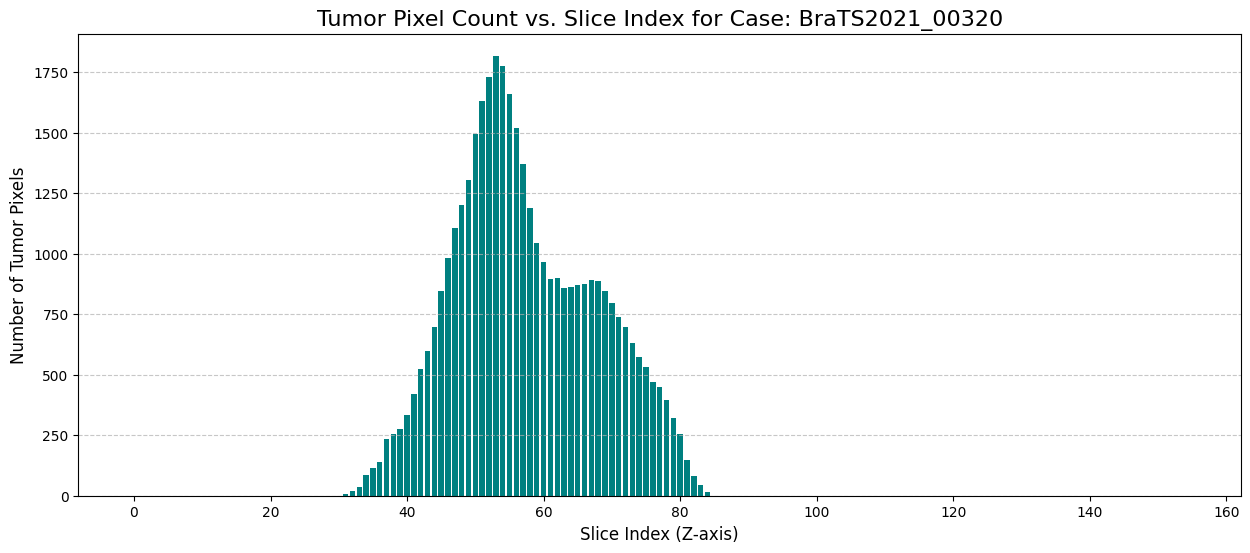

In [6]:
# Visualization of Tumor Pixel Count per Slice
print("\n Visualizing Tumor Distribution for a Sample Case")
try:
    sample_case_id = all_cases[0]
    _, mask_3d = load_brats_case(sample_case_id)

    # Calculate the number of tumor pixels for each slice
    tumor_pixel_counts = [np.sum(mask_3d[..., z] > 0) for z in range(mask_3d.shape[2])]
    slice_indices = range(mask_3d.shape[2]) # Fixed: This was on the wrong line

    # Plotting the results
    plt.figure(figsize=(15, 6))
    plt.bar(slice_indices, tumor_pixel_counts, color='teal')
    plt.title(f'Tumor Pixel Count vs. Slice Index for Case: {sample_case_id}', fontsize=16)
    plt.xlabel('Slice Index (Z-axis)', fontsize=12)
    plt.ylabel('Number of Tumor Pixels', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

except Exception as e:
    print(f"Could not generate tumor distribution plot. Error: {e}")

\n Visualizing Modalities for Case BraTS2021_00320 


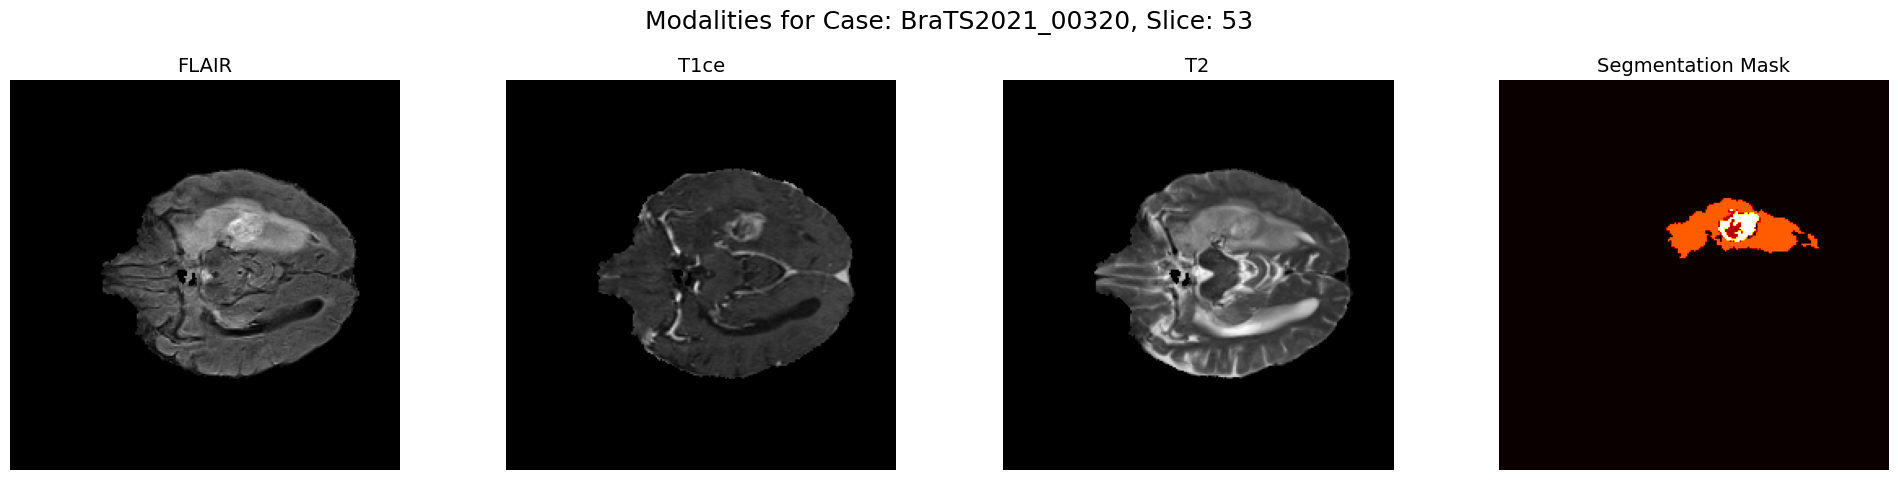

In [7]:
# Visualization of MRI Modalities for a Sample Slice
print(f"\\n Visualizing Modalities for Case {sample_case_id} ")
try:
    # Using the same sample case and finding the slice with the most tumor pixels
    data_3d, mask_3d = load_brats_case(sample_case_id)
    tumor_pixel_counts = [np.sum(mask_3d[..., z] > 0) for z in range(mask_3d.shape[2])]
    
    # Selecting the slice index with the largest tumor area for visualization
    slice_to_show = np.argmax(tumor_pixel_counts)

    # Extract the slices for each modality
    flair_slice = data_3d['flair'][..., slice_to_show]
    t1ce_slice = data_3d['t1ce'][..., slice_to_show]
    t2_slice = data_3d['t2'][..., slice_to_show]
    seg_slice = mask_3d[..., slice_to_show]

    # Plotting the four images
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f'Modalities for Case: {sample_case_id}, Slice: {slice_to_show}', fontsize=18)
    
    axes[0].imshow(flair_slice, cmap='gray')
    axes[0].set_title('FLAIR', fontsize=14)
    axes[0].axis('off')
    
    axes[1].imshow(t1ce_slice, cmap='gray')
    axes[1].set_title('T1ce', fontsize=14)
    axes[1].axis('off')
    
    axes[2].imshow(t2_slice, cmap='gray')
    axes[2].set_title('T2', fontsize=14)
    axes[2].axis('off')
    
    axes[3].imshow(seg_slice, cmap='hot')
    axes[3].set_title('Segmentation Mask', fontsize=14)
    axes[3].axis('off')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

except Exception as e:
    print(f"Could not generate modality visualization. Error: {e}")

In [8]:
#Preprocess and save all cases into slices
def preprocess_and_save_all_cases(case_ids, output_dir, pretrain_mode=False,
                                  include_negatives=True, neg_pos_ratio=0.5,
                                  max_negs_per_case=20):
    os.makedirs(output_dir, exist_ok=True)
    print(f"Preprocessing data and saving to '{output_dir}'...")
    slices_saved_count = 0
    rng = np.random.default_rng(Constants.RANDOM_STATE)

    for case_id in tqdm(case_ids, desc=f"Processing cases for {os.path.basename(output_dir)}"):
        try:
            data, mask_3d = load_brats_case(case_id)
            pos_idxs = [z for z in range(mask_3d.shape[2]) if np.any(mask_3d[..., z])]
            neg_idxs = [z for z in range(mask_3d.shape[2]) if not np.any(mask_3d[..., z])]

            selected_neg_idxs = []
            if include_negatives and len(neg_idxs) > 0 and len(pos_idxs) > 0:
                target_negs = int(np.ceil(len(pos_idxs) * neg_pos_ratio))
                target_negs = min(target_negs, max_negs_per_case, len(neg_idxs))
                selected_neg_idxs = list(rng.choice(neg_idxs, size=target_negs, replace=False))

            all_idxs = pos_idxs + selected_neg_idxs

            for z in all_idxs:
                img_slices, mask_2d = extract_slices(data, mask_3d, slice_idx=z)
                img, mask, _ = preprocess(img_slices, mask_2d, Constants.TARGET_SIZE)
                save_path = os.path.join(output_dir, f"{case_id}_z{z:03d}.npz")

                if pretrain_mode:
                    np.savez_compressed(save_path, image=img, mask=np.expand_dims(mask, -1))
                else:
                    bbox = mask_to_bbox(mask)
                    boxy_maps = create_boxy_prior_maps(mask, bbox)
                    bbox_broadcast = np.zeros_like(boxy_maps)
                    bbox_broadcast[0, 0, :] = bbox
                    y_true_combined = np.concatenate([
                        np.expand_dims(mask, -1),
                        boxy_maps,
                        bbox_broadcast
                    ], axis=-1).astype(np.float32)
                    np.savez_compressed(save_path, image=img, y_true=y_true_combined)
                slices_saved_count += 1
        except Exception as e:
            print(f"Error processing and saving case {case_id}: {e}. Skipping.")
    print(f"Completed. Saved a total of {slices_saved_count} slices.")

#Split data and run preprocessing
try:
    all_cases = [d for d in os.listdir(BRATS_PATH) if "BraTS" in d]
    total_needed = Constants.NUM_PRETRAIN_CASES + Constants.NUM_BOX_TRAIN_CASES + Constants.NUM_VAL_CASES
    if len(all_cases) < total_needed:
        raise ValueError(f"Not enough data found. Need {total_needed}, have {len(all_cases)}.")
    np.random.shuffle(all_cases)
except Exception as e:
    print(e)
    all_cases = []

val_end = Constants.NUM_PRETRAIN_CASES + Constants.NUM_BOX_TRAIN_CASES + Constants.NUM_VAL_CASES
pretrain_cases = all_cases[:Constants.NUM_PRETRAIN_CASES]
box_train_cases = all_cases[Constants.NUM_PRETRAIN_CASES : Constants.NUM_PRETRAIN_CASES + Constants.NUM_BOX_TRAIN_CASES]
val_cases = all_cases[Constants.NUM_PRETRAIN_CASES + Constants.NUM_BOX_TRAIN_CASES : val_end]

PREPROCESSED_PATHS = {
    'pre_train': "/kaggle/working/preprocessed/pretrain_train",
    'box_train': "/kaggle/working/preprocessed/box_train",
    'pre_val': "/kaggle/working/preprocessed/pretrain_val",
    'box_val': "/kaggle/working/preprocessed/box_val"
}
preprocess_and_save_all_cases(pretrain_cases, PREPROCESSED_PATHS['pre_train'], pretrain_mode=True, include_negatives=True, neg_pos_ratio=0.25)
preprocess_and_save_all_cases(box_train_cases, PREPROCESSED_PATHS['box_train'], pretrain_mode=False, include_negatives=True, neg_pos_ratio=0.25)
preprocess_and_save_all_cases(val_cases, PREPROCESSED_PATHS['pre_val'], pretrain_mode=True, include_negatives=True, neg_pos_ratio=1.0)
preprocess_and_save_all_cases(val_cases, PREPROCESSED_PATHS['box_val'], pretrain_mode=False, include_negatives=True, neg_pos_ratio=1.0)

#TF data pipeline generator
def create_dataset(file_paths, batch_size, pretrain=False, shuffle=True):
    def _parse_function(path):
        def _load_npz(p):
            with np.load(p.decode()) as data:
                image = data['image'].astype(np.float32)
                target = data['mask' if pretrain else 'y_true'].astype(np.float32)
            return image, target
        image, target = tf.numpy_function(_load_npz, [path], [tf.float32, tf.float32])
        img_shape = (*Constants.TARGET_SIZE, 3)
        tgt_shape = (*Constants.TARGET_SIZE, 1) if pretrain else (*Constants.TARGET_SIZE, 9)
        image.set_shape(img_shape)
        target.set_shape(tgt_shape)
        return image, target

    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    if not file_paths: return dataset
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(file_paths), reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

Preprocessing data and saving to '/kaggle/working/preprocessed/pretrain_train'...


Processing cases for pretrain_train: 100%|██████████| 100/100 [02:21<00:00,  1.41s/it]


Completed. Saved a total of 8351 slices.
Preprocessing data and saving to '/kaggle/working/preprocessed/box_train'...


Processing cases for box_train: 100%|██████████| 100/100 [03:45<00:00,  2.26s/it]


Completed. Saved a total of 8164 slices.
Preprocessing data and saving to '/kaggle/working/preprocessed/pretrain_val'...


Processing cases for pretrain_val: 100%|██████████| 30/30 [00:42<00:00,  1.41s/it]


Completed. Saved a total of 2508 slices.
Preprocessing data and saving to '/kaggle/working/preprocessed/box_val'...


Processing cases for box_val: 100%|██████████| 30/30 [01:07<00:00,  2.26s/it]

Completed. Saved a total of 2508 slices.


/tmp/ipykernel_36/3486089823.py:24: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(input_tensor=x_in, include_top=False, weights="imagenet")



 Stage 1: Supervised Pre-training with ImageNet Encoder
Found 8351 pre-training files and 2508 pre-validation files.


I0000 00:00:1756079594.981410      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


I0000 00:00:1756079631.047526     104 service.cc:148] XLA service 0x7fb3b40036c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756079631.048034     104 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756079632.694412     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


  7/522 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - dice_coef: 0.0461 - loss: 1.4245 - precision: 0.0231 - recall: 0.9414 

I0000 00:00:1756079640.520776     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


522/522 ━━━━━━━━━━━━━━━━━━━━ 69s 53ms/step - dice_coef: 0.3233 - loss: 0.1472 - precision: 0.6685 - recall: 0.3760 - val_dice_coef: 0.3259 - val_loss: 0.0730 - val_precision: 0.9964 - val_recall: 0.1766
Epoch 2/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - dice_coef: 0.7723 - loss: 0.0161 - precision: 0.8632 - recall: 0.8243 - val_dice_coef: 0.6356 - val_loss: 0.0360 - val_precision: 0.9763 - val_recall: 0.4945
Epoch 3/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - dice_coef: 0.8167 - loss: 0.0129 - precision: 0.8883 - recall: 0.8582 - val_dice_coef: 0.7148 - val_loss: 0.0281 - val_precision: 0.9596 - val_recall: 0.6076
Epoch 4/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - dice_coef: 0.8362 - loss: 0.0116 - precision: 0.8992 - recall: 0.8727 - val_dice_coef: 0.7726 - val_loss: 0.0202 - val_precision: 0.9063 - val_recall: 0.7467
Epoch 5/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - dice_coef: 0.8465 - loss: 0.0106 - precision: 0.9039 - recall: 0.8824 - val_dice_coef: 0.7843 - val

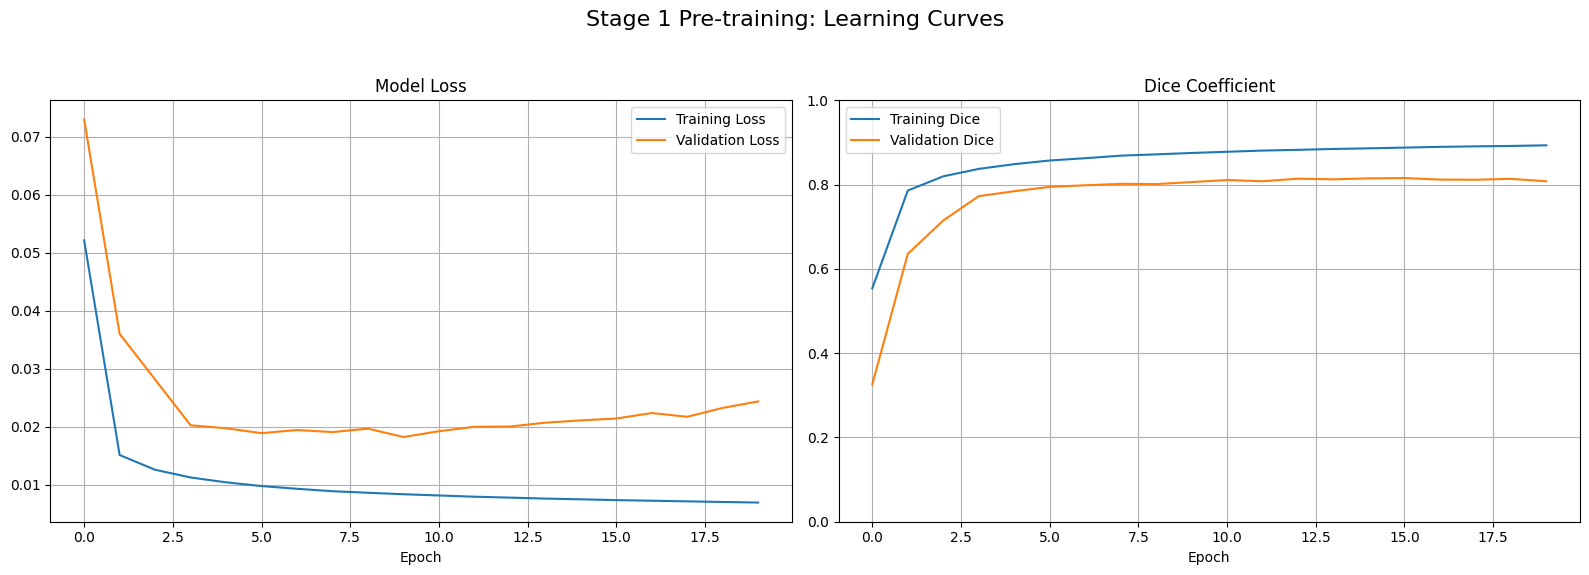

Stage 1 Complete. Encoder weights saved.


 Starting Stage 2: Deep Boxy Prior Fine-tuning
Found 8164 boxy-training files and 2508 boxy-validation files.
 Successfully loaded Stage-1 encoder weights into Stage-2 encoder.


Deep Boxy Fine-tuning:   0%|          | 0/30 [00:00<?, ?it/s]


 Phase 1: Training Decoder (Encoder Frozen)


Deep Boxy Fine-tuning:   3%|▎         | 1/30 [02:59<1:26:58, 179.96s/it]


Epoch 1/30 -> Train Loss: 0.9504 | Val Loss: 0.7340 | Val Dice: 0.5363


Deep Boxy Fine-tuning:   7%|▋         | 2/30 [05:28<1:15:27, 161.71s/it]


Epoch 2/30 -> Train Loss: 0.6731 | Val Loss: 0.6679 | Val Dice: 0.5874


Deep Boxy Fine-tuning:  10%|█         | 3/30 [07:58<1:10:12, 156.02s/it]


Epoch 3/30 -> Train Loss: 0.6050 | Val Loss: 0.5677 | Val Dice: 0.7518


Deep Boxy Fine-tuning:  13%|█▎        | 4/30 [10:27<1:06:27, 153.37s/it]


Epoch 4/30 -> Train Loss: 0.4663 | Val Loss: 0.4914 | Val Dice: 0.8117


Deep Boxy Fine-tuning:  17%|█▋        | 5/30 [12:57<1:03:21, 152.07s/it]


Epoch 5/30 -> Train Loss: 0.4361 | Val Loss: 0.4892 | Val Dice: 0.8085


Deep Boxy Fine-tuning:  20%|██        | 6/30 [15:27<1:00:34, 151.45s/it]


Epoch 6/30 -> Train Loss: 0.4233 | Val Loss: 0.4710 | Val Dice: 0.8198


Deep Boxy Fine-tuning:  23%|██▎       | 7/30 [17:59<58:10, 151.78s/it]  


Epoch 7/30 -> Train Loss: 0.4131 | Val Loss: 0.4647 | Val Dice: 0.8260


Deep Boxy Fine-tuning:  27%|██▋       | 8/30 [20:31<55:37, 151.72s/it]


Epoch 8/30 -> Train Loss: 0.4066 | Val Loss: 0.4651 | Val Dice: 0.8270


Deep Boxy Fine-tuning:  30%|███       | 9/30 [23:02<53:00, 151.47s/it]


Epoch 9/30 -> Train Loss: 0.3996 | Val Loss: 0.4625 | Val Dice: 0.8279


Deep Boxy Fine-tuning:  33%|███▎      | 10/30 [25:33<50:29, 151.49s/it]


Epoch 10/30 -> Train Loss: 0.3661 | Val Loss: 0.2949 | Val Dice: 0.8161


Deep Boxy Fine-tuning:  37%|███▋      | 11/30 [28:04<47:49, 151.05s/it]


Epoch 11/30 -> Train Loss: 0.2698 | Val Loss: 0.2697 | Val Dice: 0.8316


Deep Boxy Fine-tuning:  40%|████      | 12/30 [30:32<45:06, 150.35s/it]


Epoch 12/30 -> Train Loss: 0.2593 | Val Loss: 0.2655 | Val Dice: 0.8392


Deep Boxy Fine-tuning:  43%|████▎     | 13/30 [33:02<42:35, 150.31s/it]


Epoch 13/30 -> Train Loss: 0.2548 | Val Loss: 0.2582 | Val Dice: 0.8360


Deep Boxy Fine-tuning:  47%|████▋     | 14/30 [35:33<40:04, 150.26s/it]


Epoch 14/30 -> Train Loss: 0.2480 | Val Loss: 0.2693 | Val Dice: 0.8405


Deep Boxy Fine-tuning:  50%|█████     | 15/30 [38:01<37:23, 149.55s/it]


Epoch 15/30 -> Train Loss: 0.2445 | Val Loss: 0.2953 | Val Dice: 0.8352

 Phase 2: Unfreezing Encoder & Reducing LR


Deep Boxy Fine-tuning:  53%|█████▎    | 16/30 [43:16<46:32, 199.46s/it]


Epoch 16/30 -> Train Loss: 0.2433 | Val Loss: 0.2579 | Val Dice: 0.8300


Deep Boxy Fine-tuning:  57%|█████▋    | 17/30 [48:32<50:47, 234.39s/it]


Epoch 17/30 -> Train Loss: 0.2336 | Val Loss: 0.2584 | Val Dice: 0.8356


Deep Boxy Fine-tuning:  60%|██████    | 18/30 [53:47<51:46, 258.87s/it]


Epoch 18/30 -> Train Loss: 0.2305 | Val Loss: 0.2619 | Val Dice: 0.8364


Deep Boxy Fine-tuning:  63%|██████▎   | 19/30 [59:05<50:43, 276.64s/it]


Epoch 19/30 -> Train Loss: 0.2285 | Val Loss: 0.2612 | Val Dice: 0.8407


Deep Boxy Fine-tuning:  67%|██████▋   | 20/30 [1:04:19<47:58, 287.88s/it]


Epoch 20/30 -> Train Loss: 0.2275 | Val Loss: 0.2554 | Val Dice: 0.8387


Deep Boxy Fine-tuning:  70%|███████   | 21/30 [1:09:35<44:26, 296.24s/it]


Epoch 21/30 -> Train Loss: 0.2234 | Val Loss: 0.2574 | Val Dice: 0.8360


Deep Boxy Fine-tuning:  73%|███████▎  | 22/30 [1:14:48<40:09, 301.23s/it]


Epoch 22/30 -> Train Loss: 0.2228 | Val Loss: 0.2612 | Val Dice: 0.8407


Deep Boxy Fine-tuning:  77%|███████▋  | 23/30 [1:20:08<35:47, 306.72s/it]


Epoch 23/30 -> Train Loss: 0.2213 | Val Loss: 0.2551 | Val Dice: 0.8398


Deep Boxy Fine-tuning:  80%|████████  | 24/30 [1:25:29<31:06, 311.11s/it]


Epoch 24/30 -> Train Loss: 0.2205 | Val Loss: 0.2574 | Val Dice: 0.8408


Deep Boxy Fine-tuning:  83%|████████▎ | 25/30 [1:30:52<26:13, 314.71s/it]


Epoch 25/30 -> Train Loss: 0.2176 | Val Loss: 0.2573 | Val Dice: 0.8368


Deep Boxy Fine-tuning:  87%|████████▋ | 26/30 [1:36:12<21:04, 316.18s/it]


Epoch 26/30 -> Train Loss: 0.2169 | Val Loss: 0.2576 | Val Dice: 0.8382


Deep Boxy Fine-tuning:  90%|█████████ | 27/30 [1:41:37<15:56, 318.87s/it]


Epoch 27/30 -> Train Loss: 0.2165 | Val Loss: 0.2544 | Val Dice: 0.8378


Deep Boxy Fine-tuning:  93%|█████████▎| 28/30 [1:47:01<10:41, 320.55s/it]


Epoch 28/30 -> Train Loss: 0.2135 | Val Loss: 0.2591 | Val Dice: 0.8367


Deep Boxy Fine-tuning:  97%|█████████▋| 29/30 [1:52:23<05:20, 320.79s/it]


Epoch 29/30 -> Train Loss: 0.2140 | Val Loss: 0.2582 | Val Dice: 0.8418


Deep Boxy Fine-tuning: 100%|██████████| 30/30 [1:57:41<00:00, 235.37s/it]


Epoch 30/30 -> Train Loss: 0.2124 | Val Loss: 0.2598 | Val Dice: 0.8386


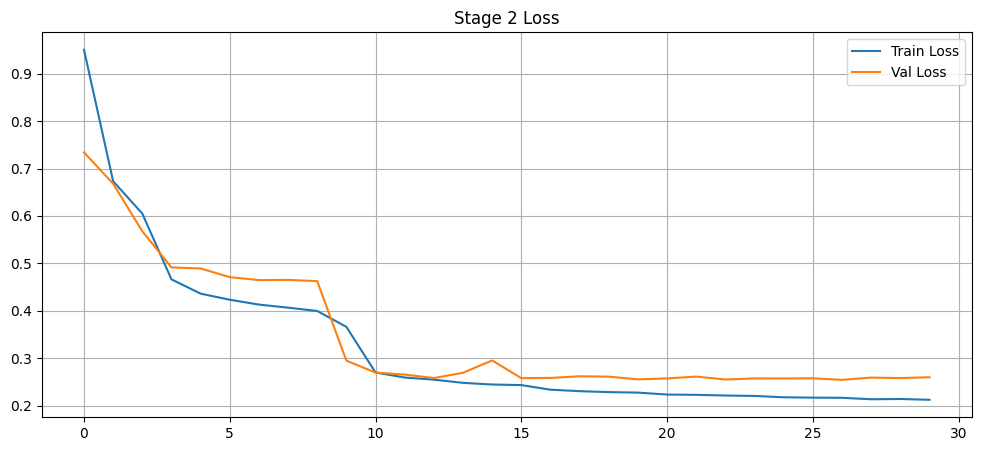

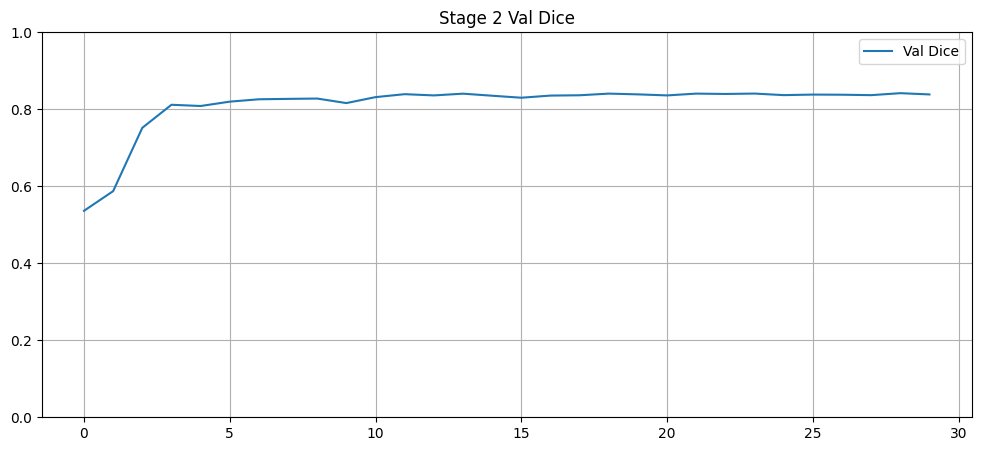

Stage 2 Complete. Final model saved. 



In [9]:
#Model Training and Evaluation

#Plotting function for learning curves
def plot_learning_curves(history, stage_name, output_path):
    print(f"\n Plotting Stage {stage_name} Learning Curves")
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f"Stage {stage_name}: Learning Curves", fontsize=16)
    
    # Loss Plot
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss'); axes[0].set_xlabel('Epoch'); axes[0].legend(); axes[0].grid(True)

    # Dice Coefficient Plot
    axes[1].plot(history.history['dice_coef'], label='Training Dice')
    axes[1].plot(history.history['val_dice_coef'], label='Validation Dice')
    axes[1].set_title('Dice Coefficient'); axes[1].set_xlabel('Epoch'); axes[1].set_ylim(0, 1); axes[1].legend(); axes[1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(output_path, dpi=300)
    plt.show()

# Stage 1: Supervised Pre-training
print("\n Stage 1: Supervised Pre-training with ImageNet Encoder")
pretrain_files = glob.glob(os.path.join(PREPROCESSED_PATHS['pre_train'], "*.npz"))
val_pretrain_files = glob.glob(os.path.join(PREPROCESSED_PATHS['pre_val'], "*.npz"))
print(f"Found {len(pretrain_files)} pre-training files and {len(val_pretrain_files)} pre-validation files.")

if pretrain_files and val_pretrain_files:
    encoder_pretrain = build_encoder_imagenet_compat(
        input_shape=(*Constants.TARGET_SIZE, 3), 
        trainable=True
    )
    full_unet_model = build_pretrain_decoder(encoder_pretrain)
    full_unet_model.compile(optimizer=Adam(Constants.LEARNING_RATE_PRETRAIN),
                            loss='binary_crossentropy',
                            metrics=[dice_coef, precision, recall])
    
    pretrain_ds = create_dataset(pretrain_files, Constants.BATCH_SIZE, pretrain=True)
    val_pretrain_ds = create_dataset(val_pretrain_files, Constants.BATCH_SIZE, pretrain=True, shuffle=False)
    
    history_pretrain = full_unet_model.fit(
        pretrain_ds, validation_data=val_pretrain_ds, epochs=Constants.EPOCHS_PRETRAIN
    )
    
    plot_learning_curves(history_pretrain, "1 Pre-training", f"{Constants.OUTPUT_PATH}/lc_stage1.png")

    # Save the encoder weights for the next stage
    encoder_pretrain.save_weights(f"{Constants.OUTPUT_PATH}/encoder_pretrain_imagenet_compat.weights.h5")
    print("Stage 1 Complete. Encoder weights saved.\n")
else:
    print("Skipping Stage 1 due to lack of data.")

#Stage 2: Deep Boxy Prior Fine-tuning
print("\n Starting Stage 2: Deep Boxy Prior Fine-tuning")
train_files = glob.glob(os.path.join(PREPROCESSED_PATHS['box_train'], "*.npz"))
val_files = glob.glob(os.path.join(PREPROCESSED_PATHS['box_val'], "*.npz"))
print(f"Found {len(train_files)} boxy-training files and {len(val_files)} boxy-validation files.")

if train_files and val_files:
    encoder_box = build_encoder_imagenet_compat(
        input_shape=(*Constants.TARGET_SIZE, 3), 
        trainable=False 
    )
    box_model = build_boxy_decoder(encoder_box)
    
    try:
        encoder_box.load_weights(f"{Constants.OUTPUT_PATH}/encoder_pretrain_imagenet_compat.weights.h5")
        print(" Successfully loaded Stage-1 encoder weights into Stage-2 encoder.")
    except Exception as e:
        print(f" Warning: Could not load pre-trained weights. Fine-tuning from ImageNet weights. Error: {e}")

    optimizer = Adam(Constants.LEARNING_RATE_FINETUNE_FROZEN)
    train_ds = create_dataset(train_files, Constants.BATCH_SIZE, pretrain=False)
    val_ds = create_dataset(val_files, Constants.BATCH_SIZE, pretrain=False, shuffle=False)
    
    history_stage2 = {"train_loss": [], "val_loss": [], "val_dice": [], "val_precision": [], "val_recall": []}
    total_epochs_box = Constants.EPOCHS_PHASE_1 + Constants.EPOCHS_PHASE_2

    for epoch in tqdm(range(total_epochs_box), desc="Deep Boxy Fine-tuning"):
        if epoch == 0: print(f"\n Phase 1: Training Decoder (Encoder Frozen)")
        if epoch == Constants.EPOCHS_PHASE_1:
            print(f"\n Phase 2: Unfreezing Encoder & Reducing LR")
            for layer in encoder_box.layers:
                layer.trainable = True
            
            optimizer = Adam(Constants.LEARNING_RATE_FINETUNE_UNFROZEN)

        # Training
        epoch_losses = []
        for images, y_true in train_ds:
            with tf.GradientTape() as tape:
                y_pred = box_model(images, training=True)
                loss = deep_boxy_loss(y_true, y_pred, Constants.BOX_CONSTRAINT_WEIGHT, Constants.BOXY_PRIOR_WEIGHT)
            grads = tape.gradient(loss, box_model.trainable_variables)
            optimizer.apply_gradients(zip(grads, box_model.trainable_variables))
            epoch_losses.append(loss.numpy())
        history_stage2["train_loss"].append(np.mean(epoch_losses))

        # Validation Step
        val_losses, val_dices, val_precs, val_recs = [], [], [], []
        for val_img, val_y_true in val_ds:
            val_pred = box_model(val_img, training=False)
            val_losses.append(deep_boxy_loss(val_y_true, val_pred, Constants.BOX_CONSTRAINT_WEIGHT, Constants.BOXY_PRIOR_WEIGHT).numpy())
            val_dices.append(dice_coef(val_y_true[..., :1], val_pred[..., :1]).numpy())
            val_precs.append(precision(val_y_true[..., :1], val_pred[..., :1]).numpy())
            val_recs.append(recall(val_y_true[..., :1], val_pred[..., :1]).numpy())
        history_stage2["val_loss"].append(np.mean(val_losses))
        history_stage2["val_dice"].append(np.mean(val_dices))
        history_stage2["val_precision"].append(np.mean(val_precs))
        history_stage2["val_recall"].append(np.mean(val_recs))

        print(f"\nEpoch {epoch+1}/{total_epochs_box} -> Train Loss: {history_stage2['train_loss'][-1]:.4f} | Val Loss: {history_stage2['val_loss'][-1]:.4f} | Val Dice: {history_stage2['val_dice'][-1]:.4f}")

    # Simplified plotting for stage 2
    plt.figure(figsize=(12, 5)); plt.plot(history_stage2["train_loss"], label="Train Loss"); plt.plot(history_stage2["val_loss"], label="Val Loss"); plt.title("Stage 2 Loss"); plt.legend(); plt.grid(True); plt.show()
    plt.figure(figsize=(12, 5)); plt.plot(history_stage2["val_dice"], label="Val Dice"); plt.title("Stage 2 Val Dice"); plt.legend(); plt.grid(True); plt.ylim(0,1); plt.show()

    box_model.save(f"{Constants.OUTPUT_PATH}/boxy_prior_model.h5")
    print("Stage 2 Complete. Final model saved. \n")
else:
    print("Skipping Stage 2 due to lack of data.")


 Starting Final Visualization on Hold-out Cases 

Visualizing the first 10 of 1021 hold-out cases...

Visualizing results for case: BraTS2021_00725


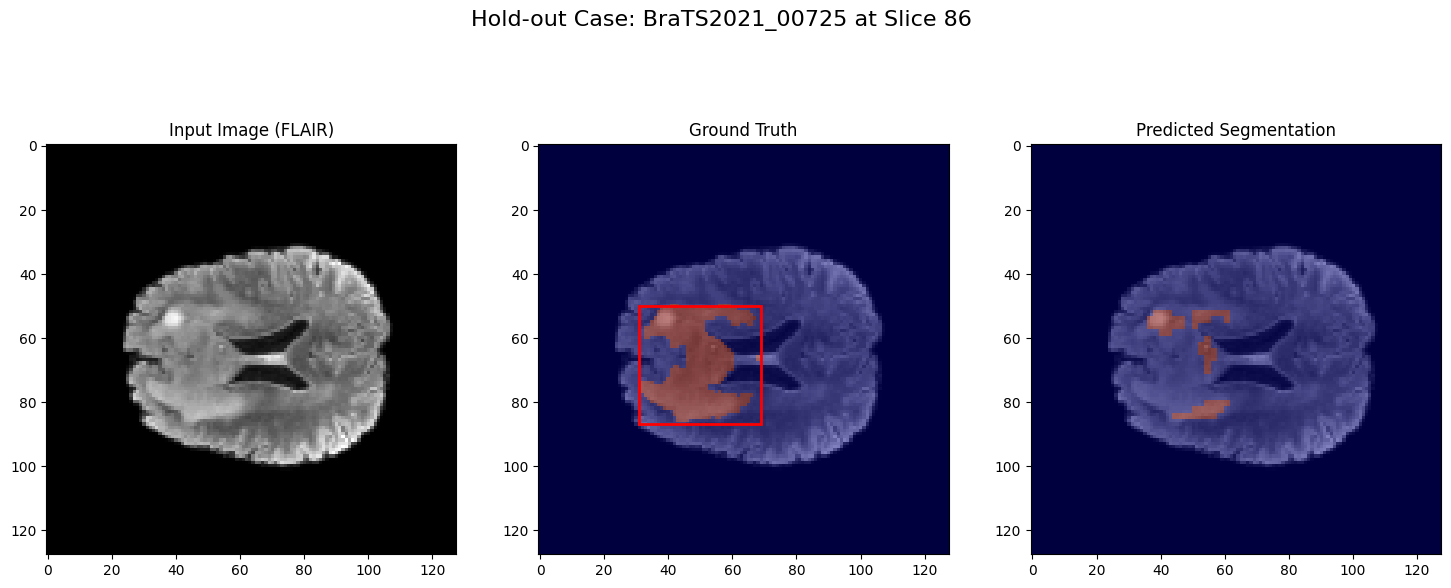


Visualizing results for case: BraTS2021_01628


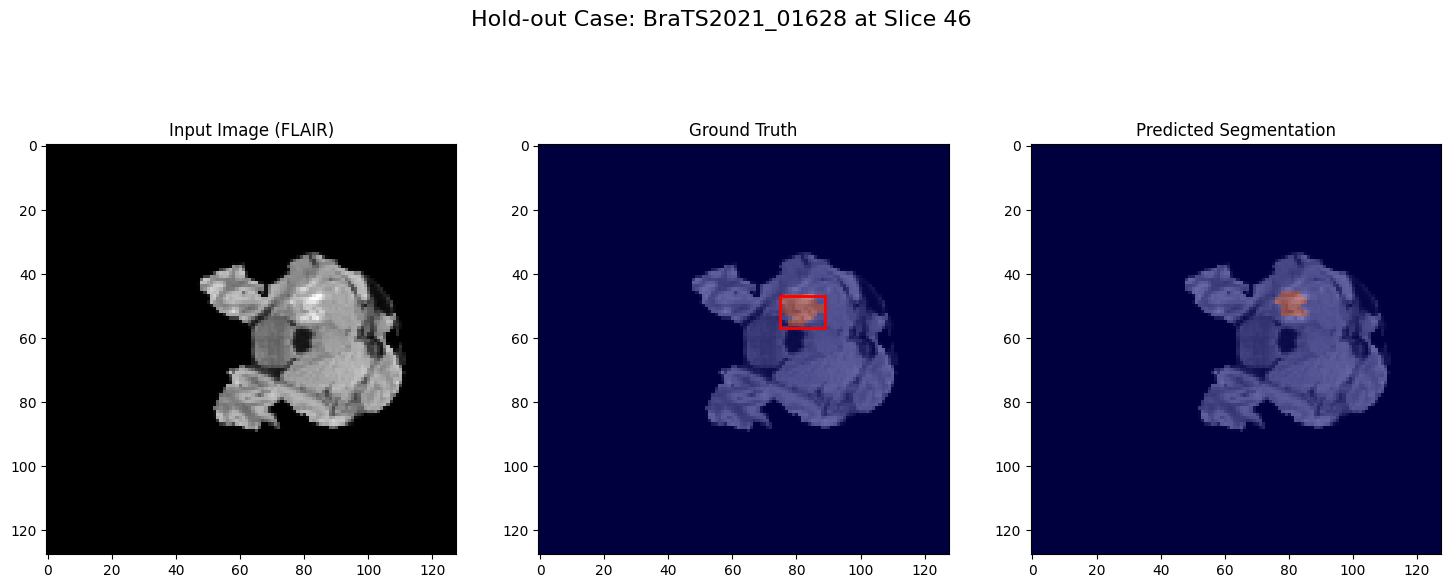


Visualizing results for case: BraTS2021_01070


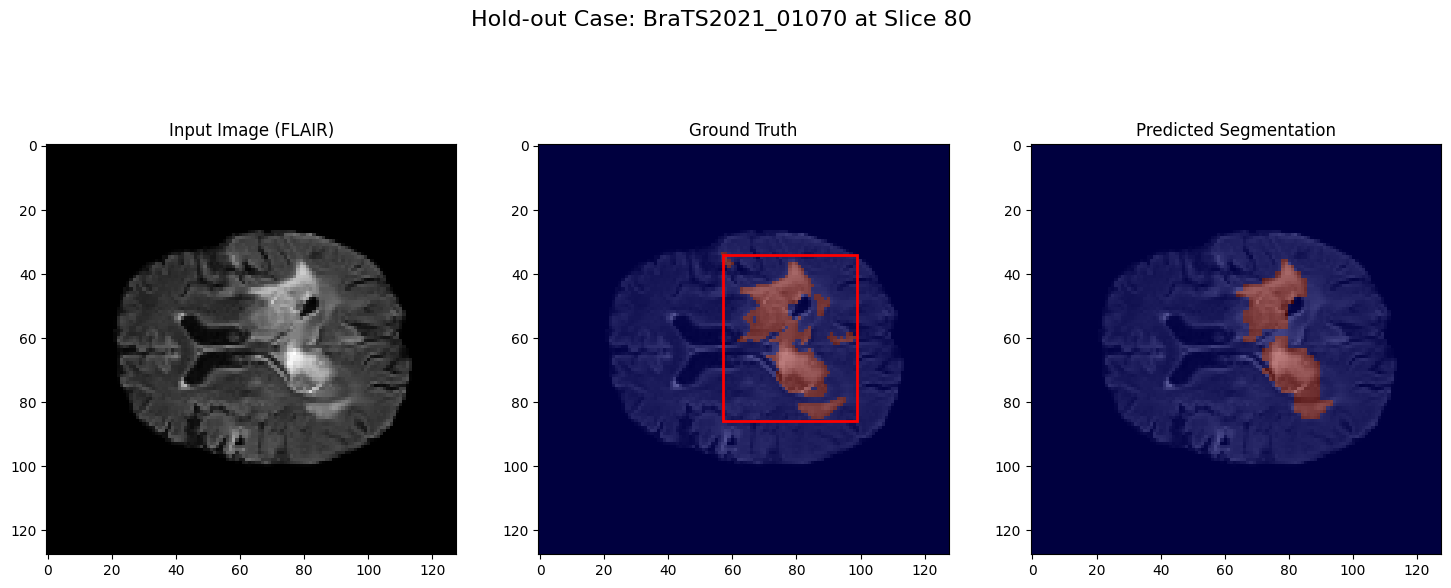


Visualizing results for case: BraTS2021_00433


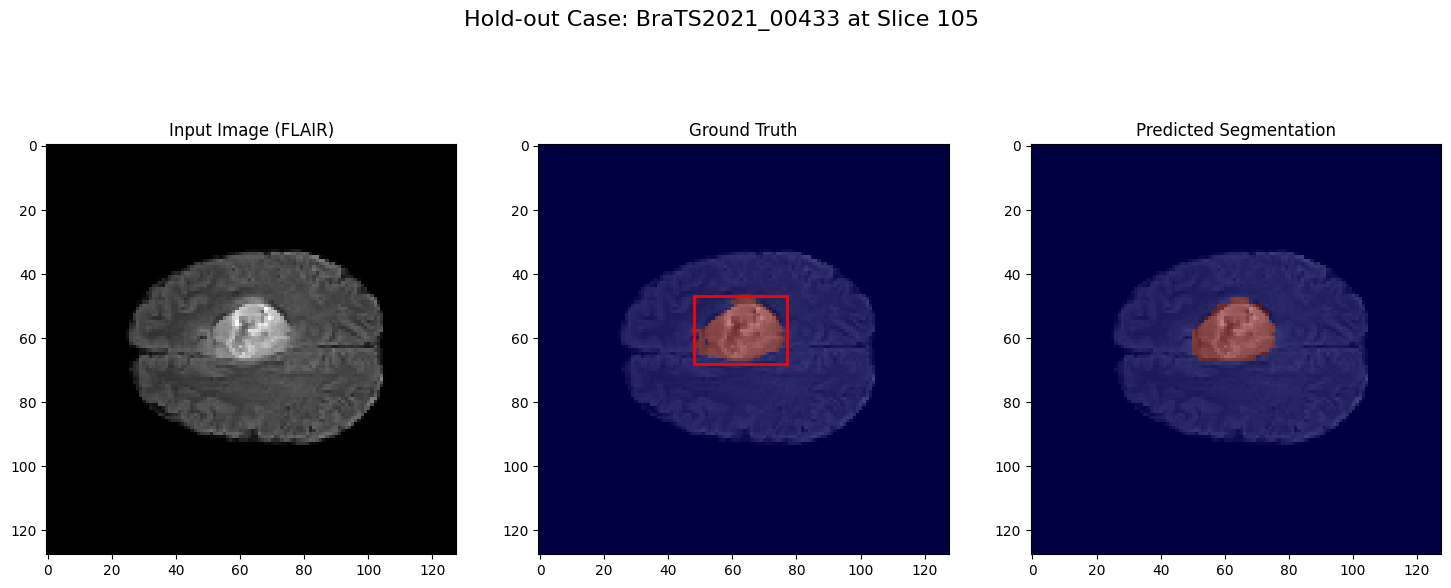


Visualizing results for case: BraTS2021_01210


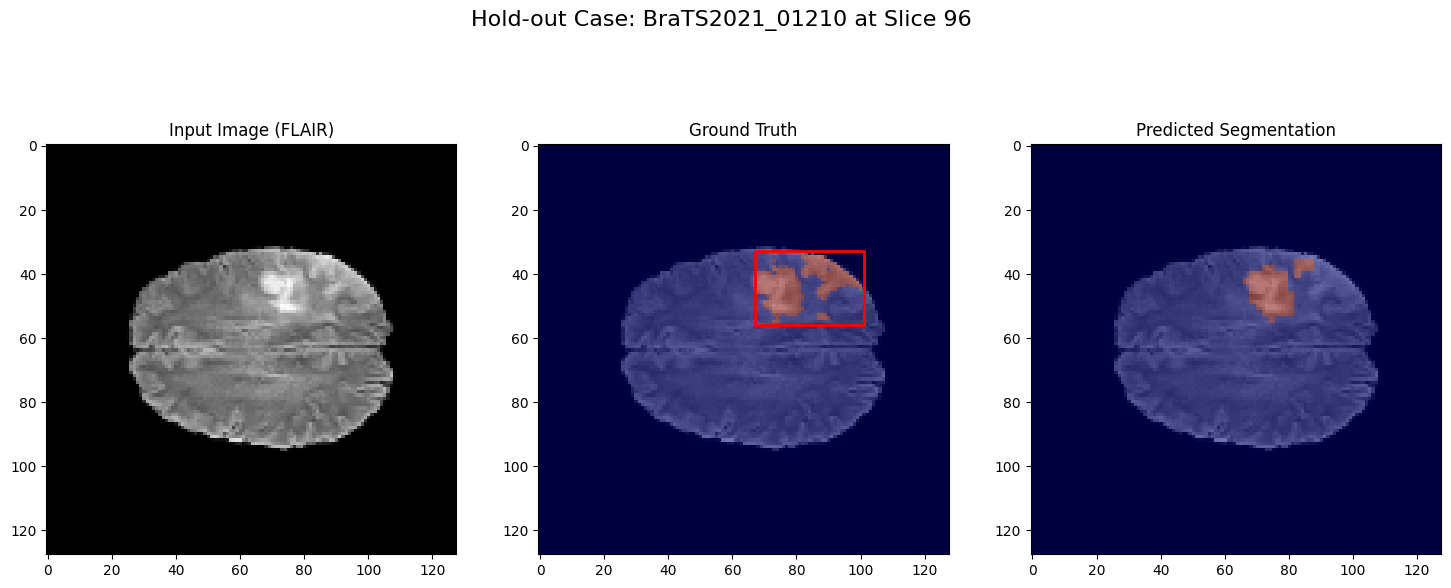


Visualizing results for case: BraTS2021_01396


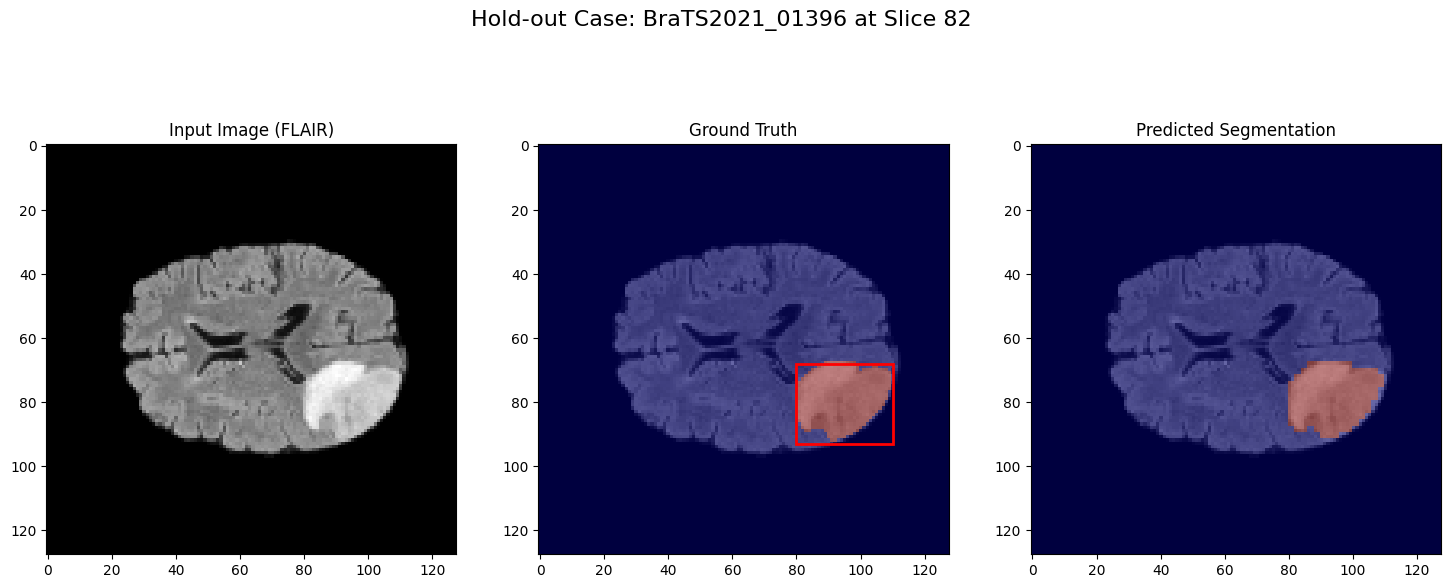


Visualizing results for case: BraTS2021_00162


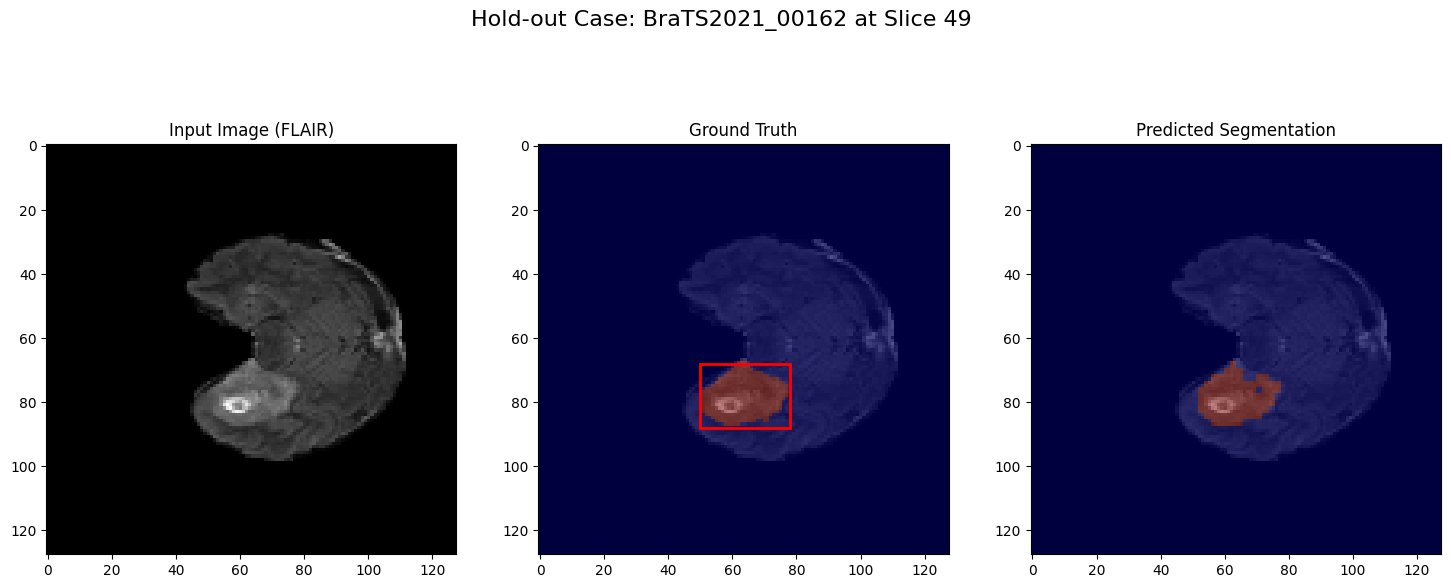


Visualizing results for case: BraTS2021_00551


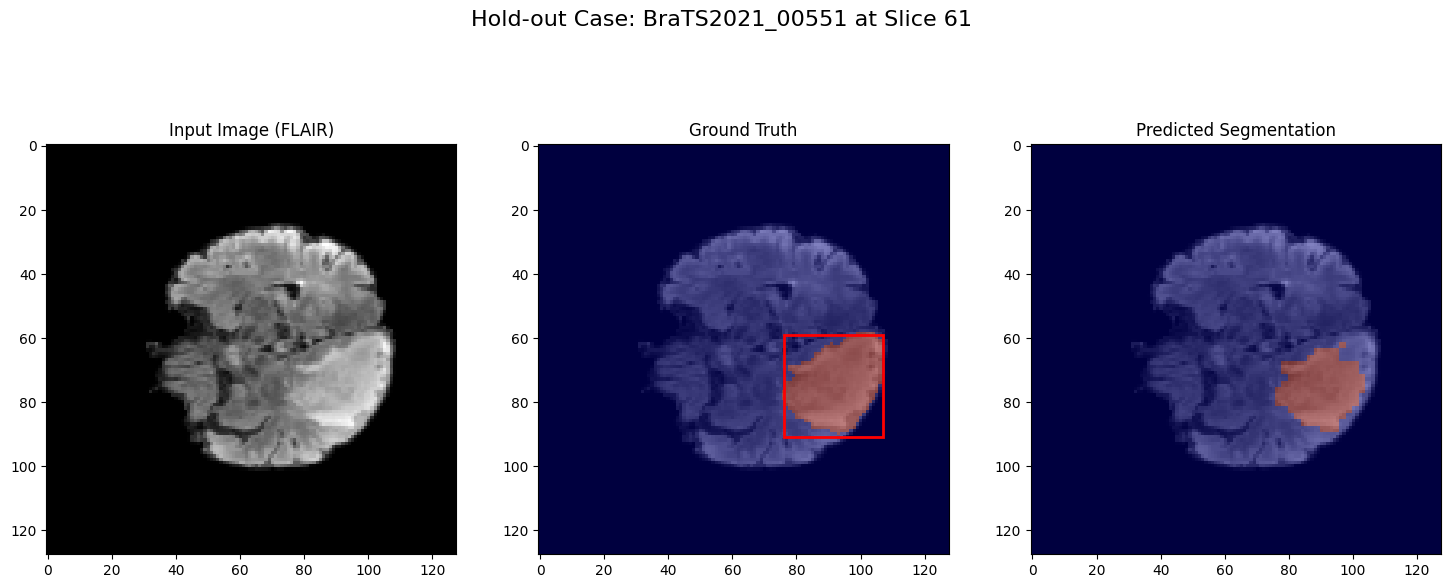


Visualizing results for case: BraTS2021_00061


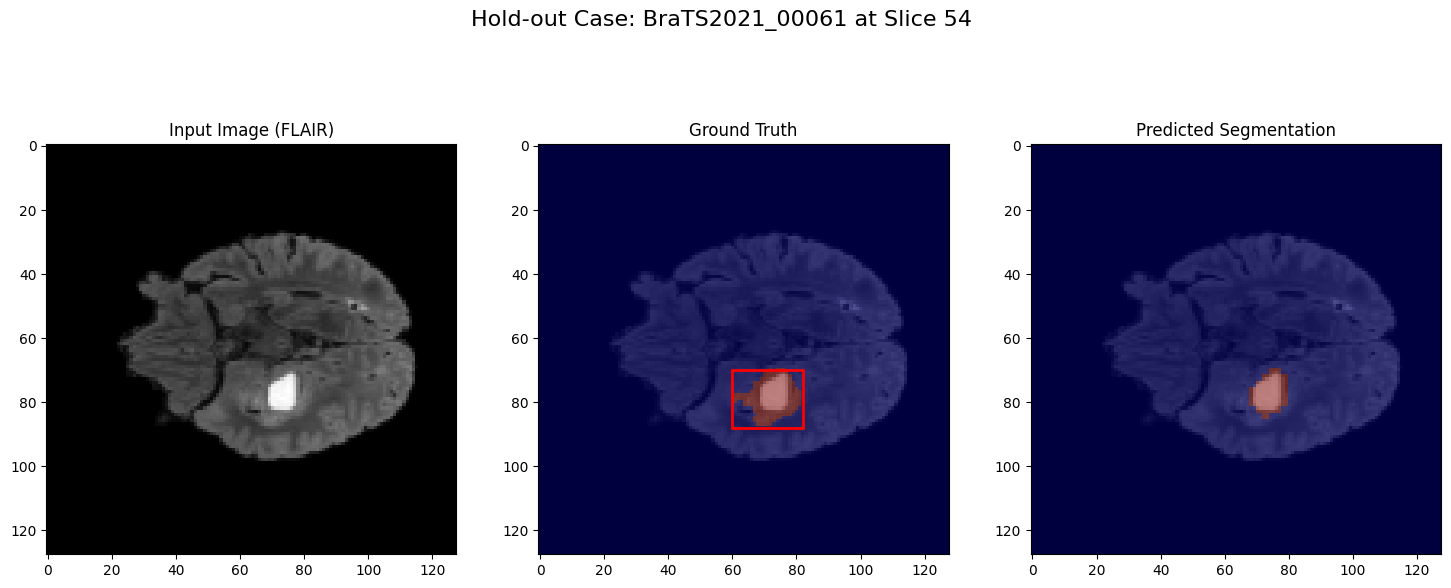


Visualizing results for case: BraTS2021_00375


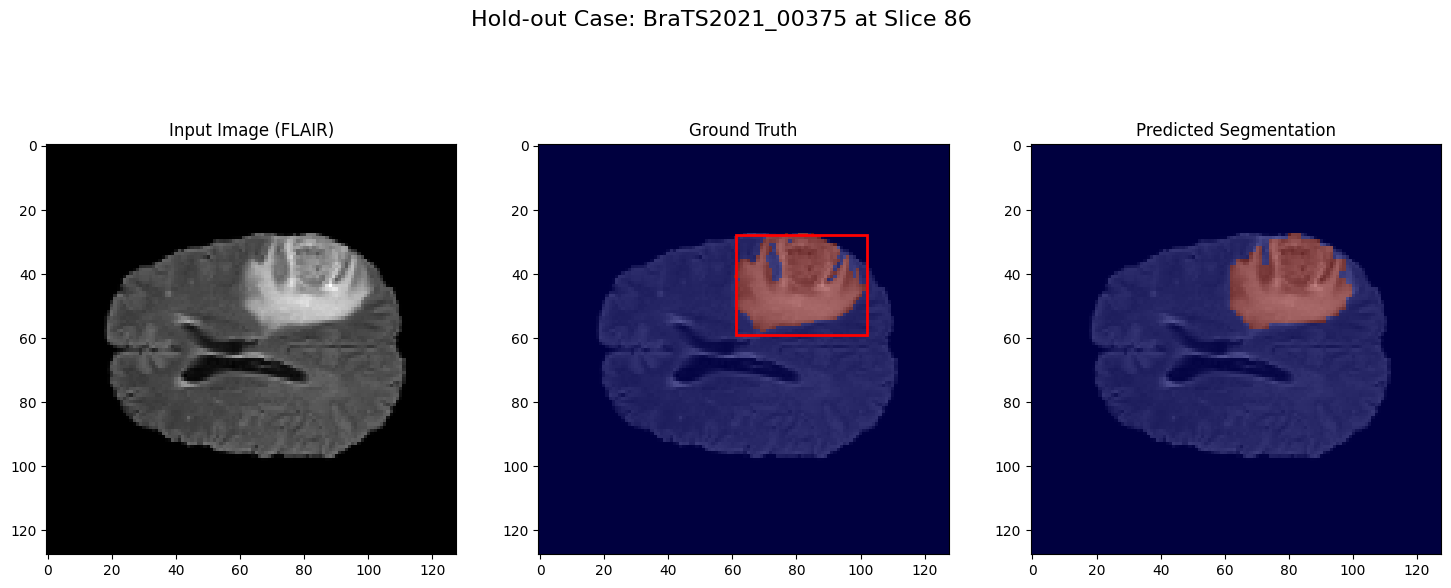

Total runtime: 7925.21 seconds (2.20 hours)


In [10]:
#Final Visualization and Runtime

#Visualization functions for inference
def visualize_results(model, case_id, target_size=(128, 128)):
    print(f"\nVisualizing results for case: {case_id}")
    try:
        data, mask_3d = load_brats_case(case_id)
        
        non_empty_slices = np.where(np.any(mask_3d, axis=(0, 1)))[0]
        if len(non_empty_slices) == 0:
            print(f"Case {case_id} has no tumor slices. Skipping visualization.")
            return
        slice_idx = non_empty_slices[len(non_empty_slices) // 2]
        
        img_slices, mask_2d = extract_slices(data, mask_3d, slice_idx=slice_idx)
        img, mask, _ = preprocess(img_slices, mask_2d, target_size=target_size)

        pred_combined = model.predict(np.expand_dims(img, 0), verbose=0)[0]
        pred_mask = (pred_combined[..., 0] > 0.5).astype(np.float32)
        bbox = mask_to_bbox(mask)
        y_min, y_max, x_min, x_max = bbox

        plt.figure(figsize=(18, 7))
        plt.suptitle(f'Hold-out Case: {case_id} at Slice {slice_idx}', fontsize=16)
        plt.subplot(131); plt.imshow(img[..., 0], cmap='gray'); plt.title(f"Input Image (FLAIR)")
        plt.subplot(132); plt.imshow(img[..., 0], cmap='gray'); plt.imshow(mask, cmap='jet', alpha=0.5)
        if np.any(bbox): plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, fill=False, edgecolor='red', linewidth=2))
        plt.title("Ground Truth")
        plt.subplot(133); plt.imshow(img[..., 0], cmap='gray'); plt.imshow(pred_mask, cmap='jet', alpha=0.5)
        plt.title("Predicted Segmentation")
        plt.savefig(f"{Constants.OUTPUT_PATH}/result_{case_id}_final_boxy.png", dpi=300)
        plt.show()

    except Exception as e:
        print(f"Could not visualize results for {case_id}. Error: {e}")

def visualize_batch_results(model, images, y_trues, num_to_show=6):
    print(f"\n Visualizing a batch of {num_to_show} validation cases post-training")
    
    actual_num_to_show = min(num_to_show, images.shape[0])
    if actual_num_to_show == 0:
        print("No images in the provided batch to visualize.")
        return

    predictions = model.predict(images, verbose=0)
    
    fig, axes = plt.subplots(actual_num_to_show, 3, figsize=(15, 5 * actual_num_to_show))
    if actual_num_to_show == 1:
        axes = np.array([axes])

    fig.suptitle("Final Model Predictions on a Validation Batch", fontsize=20)
    
    for i in range(actual_num_to_show):
        image = images[i, ..., 0]
        gt_mask = y_trues[i, ..., 0]
        pred_mask = (predictions[i, ..., 0] > 0.5).astype(np.float32)
        
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title(f"Case {i+1}: Input (FLAIR)"); axes[i, 0].axis('off')

        axes[i, 1].imshow(image, cmap='gray')
        axes[i, 1].imshow(gt_mask, cmap='jet', alpha=0.6)
        axes[i, 1].set_title(f"Case {i+1}: Ground Truth"); axes[i, 1].axis('off')

        axes[i, 2].imshow(image, cmap='gray')
        axes[i, 2].imshow(pred_mask, cmap='jet', alpha=0.6)
        axes[i, 2].set_title(f"Case {i+1}: Prediction"); axes[i, 2].axis('off')
            
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.savefig(f"{Constants.OUTPUT_PATH}/final_batch_visualization.png", dpi=300)
    plt.show()

#Final Visualization
print("\n Starting Final Visualization on Hold-out Cases ")
if train_files and val_files:
    try:
       
        model_path = f"{Constants.OUTPUT_PATH}/boxy_prior_model.h5"
        trained_model = tf.keras.models.load_model(model_path, custom_objects={'deep_boxy_loss': deep_boxy_loss}, compile=False)

        # Define the hold-out cases (those not used for training or validation)
        hold_out_cases = all_cases[val_end:]
        num_to_visualize = 10

        # Check if there are enough hold-out cases to visualize
        if len(hold_out_cases) >= num_to_visualize:
            print(f"\nVisualizing the first {num_to_visualize} of {len(hold_out_cases)} hold-out cases...")
            # Loop through and visualize the first 10 hold-out cases
            for case_id in hold_out_cases[:num_to_visualize]:
                visualize_results(trained_model, case_id)
        elif len(hold_out_cases) > 0:
            print(f"\nOnly {len(hold_out_cases)} hold-out cases available. Visualizing all of them...")
            for case_id in hold_out_cases:
                visualize_results(trained_model, case_id)
        else:
            print("No hold-out test cases available for final visualization.")

    except Exception as e:
        print(f"An error occurred during final visualization: {e}")
else:
    print("Skipping final visualization as training did not run.")

#Calculate and print total runtime
end_time = time.time()
runtime = end_time - start_time
print(f"Total runtime: {runtime:.2f} seconds ({runtime/3600:.2f} hours)")

\n Plotting Stage 1 Learning Curves with Markers


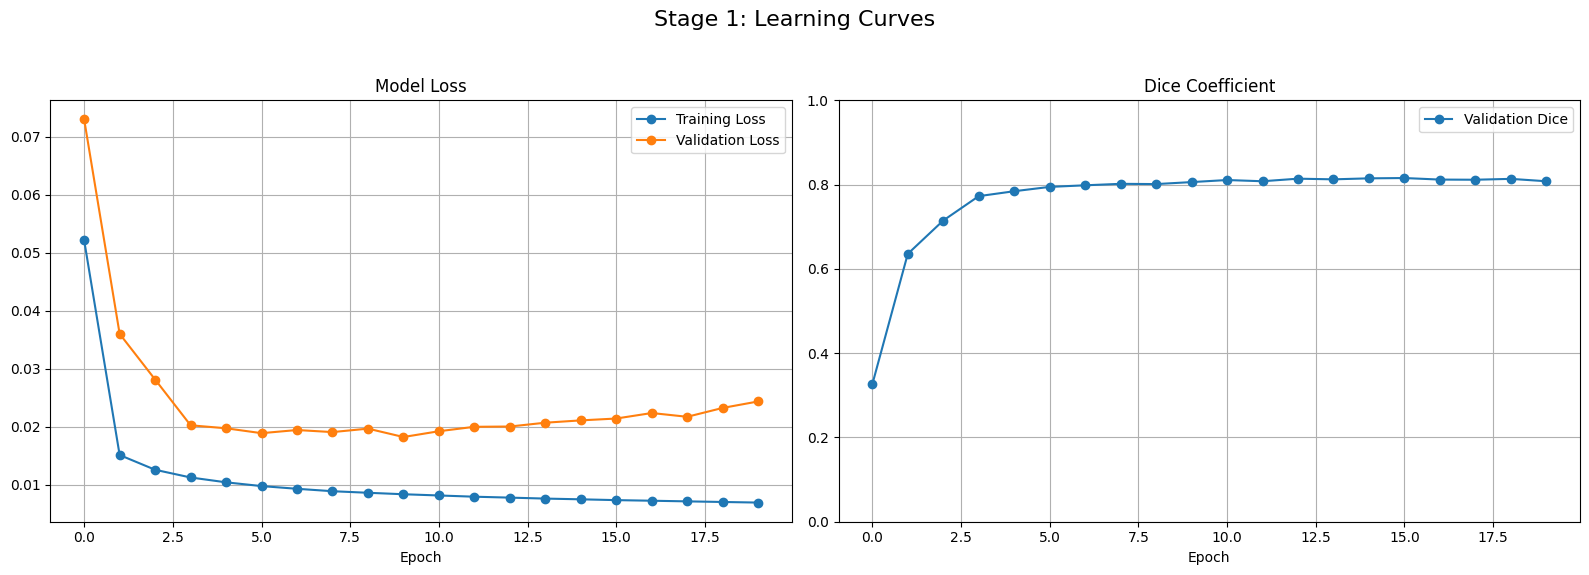

\n Plotting Stage 2 Learning Curves with Markers


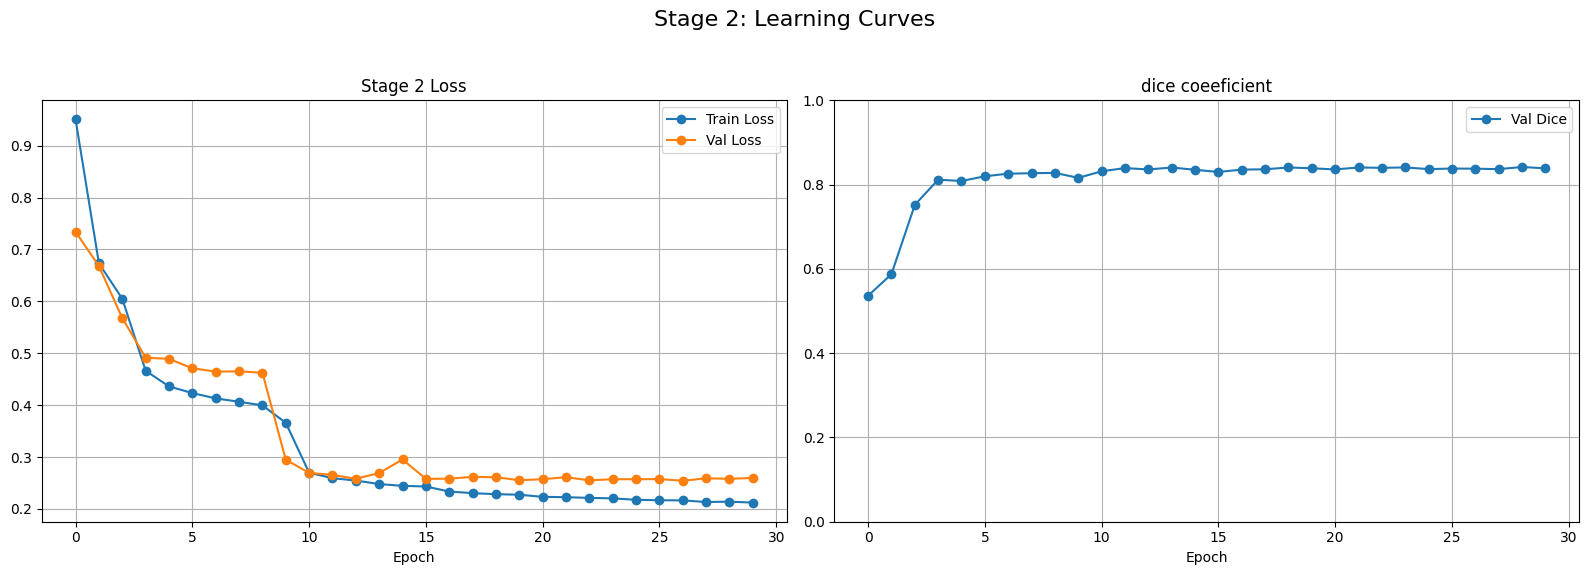

In [11]:
import matplotlib.pyplot as plt

# --- Stage 1: Pre-training Learning Curves ---
print("\\n Plotting Stage 1 Learning Curves with Markers")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Stage 1: Learning Curves", fontsize=16)

# Loss Plot for Stage 1
axes[0].plot(history_pretrain.history['loss'], 'o-', label='Training Loss')
axes[0].plot(history_pretrain.history['val_loss'], 'o-', label='Validation Loss')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(True)

# Dice Coefficient Plot for Stage 1 (Validation only)
axes[1].plot(history_pretrain.history['val_dice_coef'], 'o-', label='Validation Dice')
axes[1].set_title('Dice Coefficient')
axes[1].set_xlabel('Epoch')
axes[1].set_ylim(0, 1)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- Stage 2: Deep Boxy Prior Fine-tuning Learning Curves ---
print("\\n Plotting Stage 2 Learning Curves with Markers")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Stage 2: Learning Curves", fontsize=16)

# Loss Plot for Stage 2
axes[0].plot(history_stage2["train_loss"], 'o-', label="Train Loss")
axes[0].plot(history_stage2["val_loss"], 'o-', label="Val Loss")
axes[0].set_title("Stage 2 Loss")
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(True)

# Dice Coefficient Plot for Stage 2 (Validation only)
axes[1].plot(history_stage2["val_dice"], 'o-', label="Val Dice")
axes[1].set_title("dice coeeficient")
axes[1].set_xlabel('Epoch')
axes[1].set_ylim(0, 1)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()